In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import bmxobs
from matplotlib.colors import LogNorm

In [3]:
d = bmxobs.BMXObs("pas/210603_0600", channels="110,220,120")
d1 = bmxobs.BMXObs("pas/210618_0500", channels="110,220,120")
d2 = bmxobs.BMXObs("pas/190425_0800", channels="110,220,120")

In [4]:
d3 = bmxobs.BMXObs("pas/210626_0400", channels="110,220,120")

In [5]:
def get_cross_cut (D, fmin, fmax, ravg=10, ramin = 5.23-0.2, ramax=5.23+0.2, chan=120):
    freqcut = np.where((D.freq[0]>fmin) & (D.freq[0]<fmax))[0]
    data = D[chan][:,freqcut]
    # average in freq
    data = data.mean(axis=1)
    racut = np.where((D.ra>ramin) & (D.ra<=ramax))[0]
    racut = racut[:len(racut)//ravg*ravg]
    # average in ra
    data = data[racut]
    data=data.reshape((-1,ravg)).mean(axis=1)
    ra = D.ra[racut].reshape((-1,ravg)).mean(axis=1) 
    ra = np.unique(ra, axis = 0)
    return ra,data
    

In [7]:
# 21 06 03
ra, data = get_cross_cut(d,1400,1405)
ra_2,data_2 = get_cross_cut(d,1500,1505)

# 21 06 18
ra1, data1 = get_cross_cut(d1,1400,1405)

# 19 04 25
ra2, data2 = get_cross_cut(d2, 1400, 1405)

# 21 06 26
ra3, data3 = get_cross_cut(d3, 1100, 1400)

# data.shape

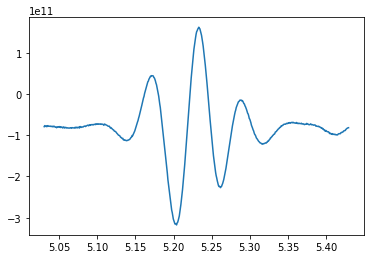

In [24]:
# plt.plot(ra,np.imag(data))
plt.plot(ra,np.real(data))

In [9]:
def cross_model(ra, ra0,ofsreal, ofsimag, A, phi, omega, sigma):
    return ofsreal+1j*ofsimag+A*np.exp(1j*(phi+omega*(ra-ra0)))*np.exp(-(ra-ra0)**2/(2*sigma**2))

/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


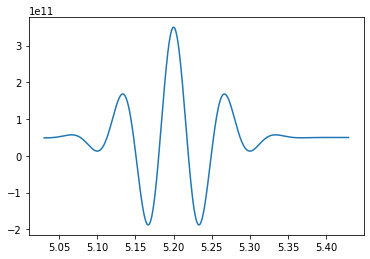

In [10]:
plt.plot(ra,cross_model(ra,5.2,+5e10,1e10,3e11,0,90,0.05))

In [11]:
class Fitter:
    def __init__ (self, ra, data):
        self.ra = ra
        self.data = data
        
    def minimize(self, startguess):
        sol = minimize(self.chi2, startguess, method='powell')
        self.bestfit = sol.x
        self.bestfitmodel = self.cross_model(*startguess)
        return sol
    
    def cross_model(self, ra0, ofsreal, ofsimag, A, phi, omega, sigma):
        return ofsreal+1j*ofsimag+A*np.exp(1j*(phi+omega*(self.ra-ra0)))*np.exp(-(self.ra-ra0)**2/(2*sigma**2))

    def chi2(self,x):
        model = self.cross_model(*x)
        chi2 = np.abs((self.data-model)**2).sum()
        #print(chi2)
        return chi2

In [46]:
guess = [5.24, 8e8, 2e8, 3.2e11, 10, 95, .05]
f=Fitter(ra,data)
f.minimize(guess)

vals = f.bestfit
names = 'ra0, ofsreal, ofsimag, A, phi, omega, sigma'.split()
for n,v in zip(names,vals):
    print (f"{n} = {v:.3e}")

ra0, = 7.901e+00
ofsreal, = 8.000e+08
ofsimag, = 2.000e+08
A, = 3.200e+11
phi, = 1.258e+01
omega, = 9.762e+01
sigma = -8.872e-01


/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/scipy/optimize/optimize.py:2965: RuntimeWarning: overflow encountered in float_scalars
  t *= temp*temp
/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/scipy/optimize/optimize.py:2967: RuntimeWarning: overflow encountered in float_scalars
  t -= delta*temp*temp
/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/scipy/optimize/optimize.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp


Text(0.5, 1.0, 'Real')

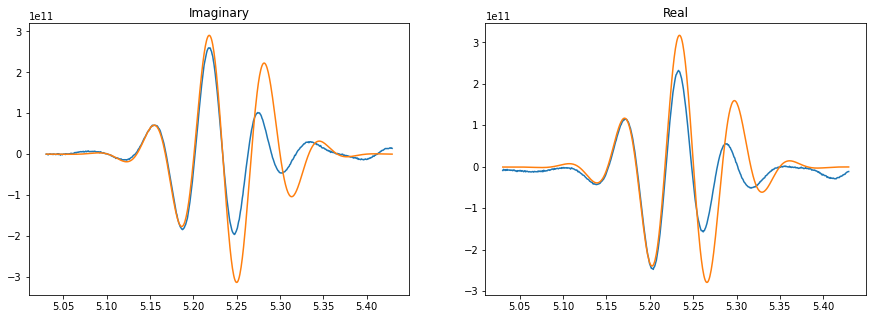

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(ra, np.imag(data)-.5e11)
ax1.plot(ra, np.imag(f.bestfitmodel))
ax1.set_title('Imaginary')

ax2.plot(ra, np.real(data)+.7e11)
ax2.plot(ra, -np.real(f.bestfitmodel))
ax2.set_title('Real')